<a href="https://colab.research.google.com/github/graceetzel/Numerical-Analysis/blob/main/Etzel_Grace_Sample_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ---------------------------
# Natural cubic spline (tridiagonal matrix) + eval
# ---------------------------
def natural_cubic_spline_coeffs(xp, yp):
    """
    Build the natural cubic spline system exactly as in the text:
        - h_i = x_{i+1} - x_i
        - Δ_i = y_{i+1} - y_i
        - Unknowns: c_i  (proportional to second derivatives)
        - Natural BC: c_0 = 0, c_n = 0
        - Interior rows:  h_{i-1} c_{i-1} + 2(h_{i-1}+h_i) c_i + h_i c_{i+1}
                          = 3(Δ_i/h_i - Δ_{i-1}/Δ_{i-1}),   i = 1,...,n-1
      Then recover:
        d_i = (c_{i+1} - c_i)/(3 h_i)
        b_i = Δ_i/h_i - h_i*(2 c_i + c_{i+1})/3
      Piece on [x_i, x_{i+1}]:  S_i(x) = y_i + b_i dx + c_i dx^2 + d_i dx^3,  dx = x - x_i
    """
    xp = np.asarray(xp, dtype=float)
    yp = np.asarray(yp, dtype=float)
    if xp.ndim != 1 or yp.ndim != 1 or xp.size != yp.size:
        raise ValueError("xp and yp must be 1D arrays of the same length.")
    if not np.all(np.diff(xp) > 0):
        raise ValueError("xp must be strictly increasing.")

    m = xp.size          # number of knots
    n = m - 1            # number of intervals
    h = np.diff(xp)      # h_i = x_{i+1} - x_i, length n
    Delta = np.diff(yp)  # Δ_i = y_{i+1} - y_i, length n

    # --- Build tridiagonal matrix A and RHS r
    A = np.zeros((m, m), dtype=float)
    r = np.zeros(m, dtype=float)

    # Natural BC rows:
    A[0, 0]   = 1.0      # c_0 = 0
    A[-1, -1] = 1.0      # c_n = 0
    r[0]      = 0.0
    r[-1]     = 0.0

    # Interior rows i = 1,...,n-1
    for i in range(1, n):
        A[i, i-1] = h[i-1]
        A[i, i]   = 2.0 * (h[i-1] + h[i])
        A[i, i+1] = h[i]
        r[i] = 3.0 * (Delta[i]/h[i] - Delta[i-1]/h[i-1])

    # --- Solve for c ---
    c = np.linalg.solve(A, r)

    # --- Recover b and d ---
    b = np.empty(n, dtype=float)
    d = np.empty(n, dtype=float)
    for i in range(n):
        b[i] = Delta[i]/h[i] - (h[i]/3.0) * (2.0*c[i] + c[i+1])
        d[i] = (c[i+1] - c[i]) / (3.0*h[i])

    # Return coefficients for each interval [x_i, x_{i+1}]
    # S_i(x) = y_i + b_i*(x-x_i) + c_i*(x-x_i)^2 + d_i*(x-x_i)^3
    return b, c, d

def spline_eval(xp, yp, b, c, d, xq):
    """
    Evaluate the natural cubic spline interpolant at an array of points xq.

    Parameters:
    xp : array_like
        Knot locations (x-values), assumed to be strictly increasing, length n+1
    yp : array_like
        Function values at the knots, length n+1
    b, c, d : array_like
        Spline coefficients on each subinterval [x_j, x_{j+1}], each of length n
    xq : array_like
        The x-values at which to evaluate the spline

    Returns:
    array_like
        The interpolated values S(xq)
    """
    xq = np.asarray(xq)
    # Find the index j such that xp[j] <= xq <= xp[j+1]
    # Use searchsorted to find the indices for each element in xq
    j = np.searchsorted(xp, xq, side='right') - 1
    # Clamp to valid range in case xq is outside the interval
    j = np.clip(j, 0, len(xp) - 2)

    # Compute the local offset from the left endpoint of the interval for each point in xq
    dx = xq - xp[j]

    # Evaluate the cubic polynomial on interval [xp[j], xp[j+1]] for each point in xq
    # S_j(xq) = y_j + b_j*dx + c_j*dx^2 + d_j*dx^3
    # Use broadcasting for element-wise operations
    return yp[j] + b[j]*dx + c[j]*dx*dx + d[j]*dx*dx*dx

def spline_eval_deriv(xp, y_points, b, c, d, xq):
    """
    Evaluate the first derivative of the natural cubic spline interpolant at an array of points xq.
    """
    xq = np.asarray(xq)
    # Find the index j such that xp[j] <= xq <= xp[j+1]
    # Use searchsorted to find the indices for each element in xq
    j = np.searchsorted(xp, xq, side='right') - 1
    # Clamp to valid range in case xq is outside the interval
    j = np.clip(j, 0, len(xp) - 2)

    # Compute the local offset from the left endpoint of the interval for each point in xq
    dx = xq - xp[j]

    # Evaluate the cubic polynomial on interval [xp[j], xp[j+1]] for each point in xq
    # S_j(xq) = y_j + b_j*dx + c_j*dx^2 + d_j*dx^3
    # Use broadcasting for element-wise operations
    return b[j] + 2*c[j]*dx + 3*d[j]*dx*dx


def spline_eval_second_deriv(xp, y_points, b, c, d, xq):
    """
    Evaluate the second derivative of the natural cubic spline interpolant at an array of points xq.
    """
    xq = np.asarray(xq)
    # Find the index j such that xp[j] <= xq <= xp[j+1]
    # Use searchsorted to find the indices for each element in xq
    j = np.searchsorted(xp, xq, side='right') - 1
    # Clamp to valid range in case xq is outside the interval
    j = np.clip(j, 0, len(xp) - 2)

    # Compute the local offset from the left endpoint of the interval for each point in xq
    dx = xq - xp[j]

    # Evaluate the cubic polynomial on interval [xp[j], xp[j+1]] for each point in xq
    # S_j(xq) = y_j + b_j*dx + c_j*dx^2 + d_j*dx^3
    # Use broadcasting for element-wise operations
    return 2*c[j] + 6*d[j]*dx


def curvature_from_derivs(y1, y2):
    """
    Evaluate the curvature at an array of points xq.
    """
    return np.abs(y2)/(1+(y1**2)**(3/2))

              x         y
0    295.454545 -0.807360
1    681.818182 -0.454869
2    840.909091  0.165774
3   1000.000000 -0.901317
4    386.363636  0.438693
..          ...       ...
56   340.909091 -0.683837
57   295.454545 -0.807360
58   681.818182 -0.454869
59   840.909091  0.165774
60  1000.000000 -0.901317

[61 rows x 2 columns]

Original data shape: (61, 2)
Columns: ['x', 'y']

Data shape after dropping the missing rows:(59, 2)

Data shape after dropping the duplicates:(45, 2)
[[ 0.00000000e+00  6.09434160e-02]
 [ 2.27272727e+01  3.86156948e-01]
 [ 4.54545454e+01  1.12019523e+00]
 [ 6.81818182e+01  1.20683889e+00]
 [ 9.09090909e+01  3.97001091e-01]
 [ 1.13636364e+02  1.78614181e-01]
 [ 1.36363636e+02  1.78084354e-01]
 [ 1.59090909e+02 -4.44471410e-02]
 [ 1.81818182e+02 -3.37301000e-03]
 [ 2.04545455e+02 -2.00640966e-01]
 [ 2.27272727e+02 -1.30518620e-02]
 [ 2.50000000e+02 -3.39080666e-01]
 [ 2.72727273e+02 -8.23910267e-01]
 [ 2.95454545e+02 -8.07359547e-01]
 [ 3.18181818e+02 -8.37

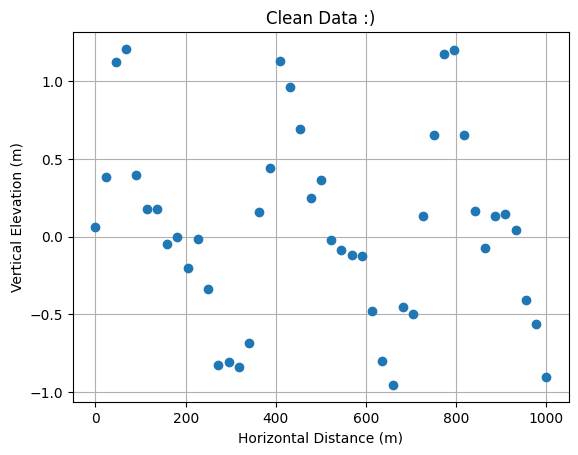

In [ ]:
# --- Load from CSV option ---
# Use a direct download link from Google Drive
google_drive_id = '1Xd3yP3sWnhz8eSmUg6kH_3SA56Fpk7lg'
download_url = f'https://drive.google.com/uc?export=download&id={google_drive_id}'

# Load data
df = pd.read_csv(download_url)

print(df)

print(f"\nOriginal data shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# Remove rows with missing values

df = df.dropna()
print(f"\nData shape after dropping the missing rows:{df.shape}")

# Remove duplicates

df = df.drop_duplicates()
print(f"\nData shape after dropping the duplicates:{df.shape}")

# Sort by x column

df = df.sort_values(by='x')

# Extract as numpy arrays

numpy_array = df.to_numpy()
print(numpy_array)

# Plot to visualize the cleaned data

numpy_array = df.to_numpy()
x_values = numpy_array[:, 0]
y_values = numpy_array[:, 1]

plt.plot(x_values, y_values,'o')
plt.xlabel('Horizontal Distance (m)')
plt.ylabel('Vertical Elevation (m)')
plt.title('Clean Data :)')
plt.grid(True)
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


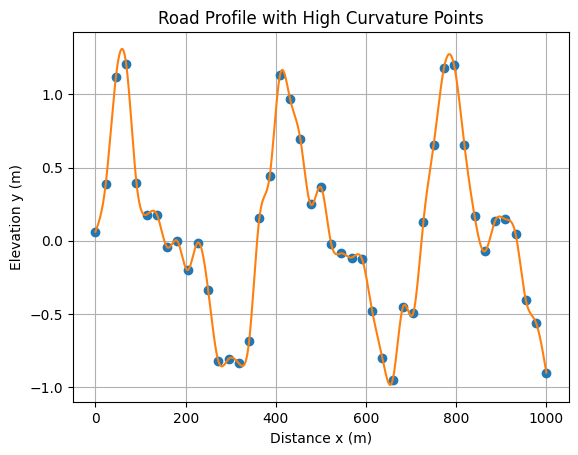

In [ ]:
# Natural cubic spline coefficients

b, c, d = natural_cubic_spline_coeffs(x_values, y_values)

# Evaluate spline on dense grid

xq = np.linspace(np.min(x_values), np.max(x_values), 1000)
ys = spline_eval(x_values, y_values, b, c, d, xq)

# Plot road profiles: cleaned data and natural cubic spline

plt.plot(x_values, y_values, 'o', label='Original Data')
plt.plot(xq, ys, label='Natural Cubic Spline')
plt.xlabel('Distance x (m)')
plt.ylabel('Elevation y (m)')

# Add the flagged high curvature points to the plot
# Ensure high_curvature_x and high_curvature_y are available from previous execution
if 'high_curvature_x' in locals() and 'high_curvature_y' in locals():
    plt.scatter(high_curvature_x, high_curvature_y, color='red', zorder=5, label='Top 2% Curvature Points')
    plt.legend()

plt.title('Road Profile with High Curvature Points')
plt.grid(True)
plt.show()

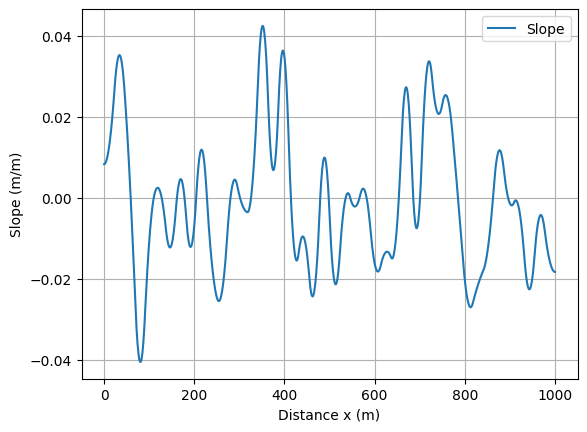

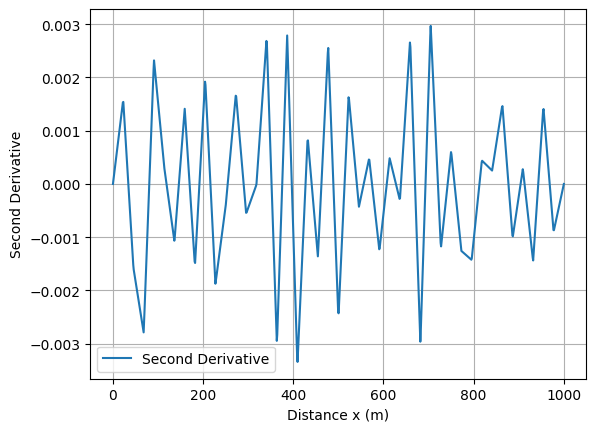

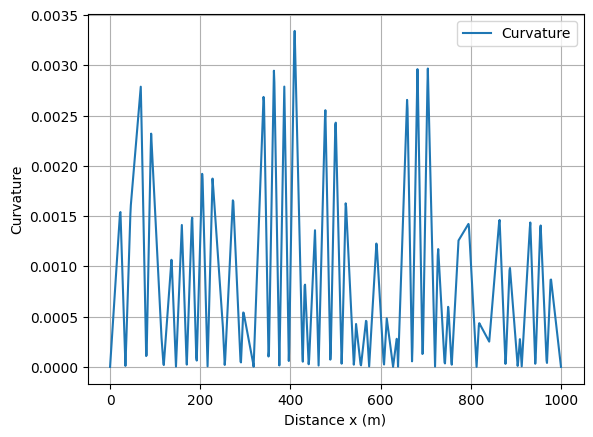

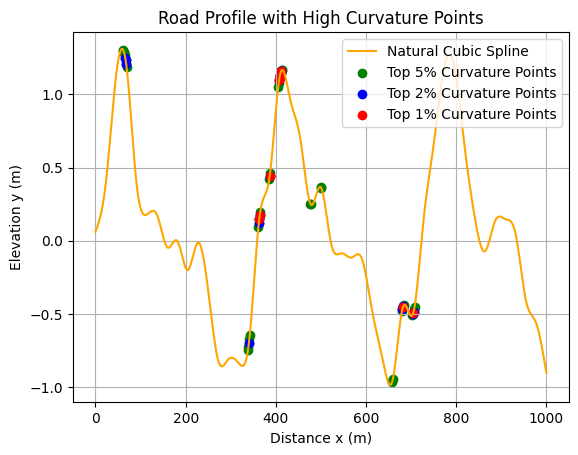

In [ ]:
# Calculate derivatives & curvature from custom spline

spline_first_deriv = spline_eval_deriv(x_values, y_values, *natural_cubic_spline_coeffs(x_values, y_values), xq)

spline_second_deriv = spline_eval_second_deriv(x_values, y_values, *natural_cubic_spline_coeffs(x_values, y_values), xq)

curvature = curvature_from_derivs(spline_first_deriv, spline_second_deriv)

# Plot slope

plt.plot(xq, spline_first_deriv, label='Slope')
plt.xlabel('Distance x (m)')
plt.ylabel('Slope (m/m)')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(xq, spline_second_deriv, label='Second Derivative')
plt.xlabel('Distance x (m)')
plt.ylabel('Second Derivative')
plt.legend()
plt.grid(True)
plt.show()

# Plot curvature

plt.plot(xq, curvature, label='Curvature')
plt.xlabel('Distance x (m)')
plt.ylabel('Curvature')
plt.legend()
plt.grid(True)
plt.show()

# Flag top 1% curvature points

curvature_threshold_1 = np.percentile(curvature, 99)

high_curvature_indices_1 = np.where(curvature > curvature_threshold_1)[0]

high_curvature_x_1 = xq[high_curvature_indices_1]
high_curvature_y_1 = ys[high_curvature_indices_1]


# Flag top 2% curvature points

curvature_threshold = np.percentile(curvature, 98)

high_curvature_indices = np.where(curvature > curvature_threshold)[0]

high_curvature_x = xq[high_curvature_indices]
high_curvature_y = ys[high_curvature_indices]

#Flag top 5% curvature points

curvature_threshold_5 = np.percentile(curvature, 95)

high_curvature_indices_5 = np.where(curvature > curvature_threshold_5)[0]

high_curvature_x_5 = xq[high_curvature_indices_5]
high_curvature_y_5 = ys[high_curvature_indices_5]


# Plot road profiles: cleaned data, natural cubic spline, and flagged points

#plt.plot(x_values, y_values, 'o', label='Original Data')
plt.plot(xq, ys, label='Natural Cubic Spline', color="orange")
plt.scatter(high_curvature_x_5, high_curvature_y_5, color='green', label='Top 5% Curvature Points')
plt.scatter(high_curvature_x, high_curvature_y, color='blue', label='Top 2% Curvature Points')
plt.scatter(high_curvature_x_1, high_curvature_y_1, color='red', label='Top 1% Curvature Points')
plt.xlabel('Distance x (m)')
plt.ylabel('Elevation y (m)')
plt.title('Road Profile with High Curvature Points')
plt.legend()
plt.grid(True)
plt.show()

# Conclusion

To understand how well the interpolation fits the data points, we take the mean of all the absolute errors as shown in the code below:

In [ ]:
# OG data points
ys_at_original_points = spline_eval(x_values, y_values, b, c, d, x_values)

# Diff between y and spline values
elevation_difference = y_values - ys_at_original_points

# Abs Error
mae = np.mean(np.abs(elevation_difference))

print(f"Mean Absolute Error: {mae:.4f}")


Mean Absolute Error: 0.0000


When we do this, notice that the mean absolute error is 0. This supports the claim that the interpolation fits the data points almost perfectly. Using curvature as flagging points allows us to look at areas of sharp deviations from flat terrain. Specifically, we look at the "sharpest" of the deviation. However, there may be some curvature points that are missing with using the percentile. That is, we miss information on areas of the road that could still have bumps/pot holes, depending on how messed up the road is. So, an alternative may be to looke a relative extrema. That is, anaylzing the maximum points and minimum points to understand all forms of deviation from 0 elevation. Caculating the difference between the extrema and elevation 0 (or potiential from the inflection points) may provide more accurate information on the bumpest parts of the road compared to just curvature.